In [1]:
!curl https://download.pytorch.org/tutorial/data.zip > data.zip
!unzip -qqo data.zip && rm data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  33.5M      0 --:--:-- --:--:-- --:--:-- 33.5M


In [2]:
import torch
import torch.nn as nn
import torch.autograd
import torch.optim as optim
from torch.autograd import Variable
import glob
import unicodedata
import string
import sys
import decimal
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
all_letters = list(string.ascii_letters + " .,;'")
all_letters += ['<EOS>', '<SOS>']
n_letters = len(all_letters)

def charToIndex(letter):
    return all_letters.index(letter)

def findFiles(path):
    return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(all_categories)

['German', 'Greek', 'Italian', 'English', 'Portuguese', 'Chinese', 'Vietnamese', 'Irish', 'Spanish', 'Arabic', 'Polish', 'Dutch', 'Czech', 'Russian', 'French', 'Scottish', 'Korean', 'Japanese']


In [4]:
def nameToTensor(name):
    return torch.LongTensor([charToIndex(char) for char in name])

def categoryTensor(category):
    cat_idx = all_categories.index(category)
    return torch.LongTensor([cat_idx])

def inputTensor(line):
    res = []
    res.append(charToIndex('<SOS>'))
    res.extend([charToIndex(char) for char in line])
    return torch.LongTensor(res)

In [5]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    char_idxs = [all_letters.index(char) for char in line]
    char_idxs.append(charToIndex('<EOS>'))
    return torch.LongTensor(char_idxs)

def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
class CharRNN(nn.Module):
    def __init__(self, input_size,
                 hidden_size,
                 output_size,
                 char_embedding_dim=110,
                 cat_embedding_dim=18):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding_cat = nn.Embedding(len(all_categories), cat_embedding_dim)
        self.embedding_char = nn.Embedding(input_size, char_embedding_dim)
        self.lstm = nn.LSTM(char_embedding_dim + cat_embedding_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):

        cat_embed = self.embedding_cat(category)
        char_embed = self.embedding_char(input)
        combined = torch.cat((cat_embed, char_embed), 1).unsqueeze(1)

        lstm_out, hidden = self.lstm(combined, hidden)
        output = self.fc(lstm_out.squeeze(1))
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return (Variable(torch.zeros(1, 1, self.hidden_size)),
                Variable(torch.zeros(1, 1, self.hidden_size)))

In [7]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    optimizer.zero_grad()
    loss = 0
    hidden = rnn.initHidden()
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i:i+1], hidden)
        loss += criterion(output, target_line_tensor[i])
    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
rnn = CharRNN(n_letters, 128, n_letters, char_embedding_dim=110, cat_embedding_dim=18)

criterion = nn.NLLLoss()
learning_rate = 0.0005
optimizer = optim.Adam(rnn.parameters(), learning_rate)

In [9]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()
for iter in range(1, n_iters + 1):

    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, total_loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

torch.save(rnn, 'char-rnn-generation.pt')

0m 40s (5000 5%) 1088.8661
1m 21s (10000 10%) 1003.0493
2m 2s (15000 15%) 919.5977
2m 43s (20000 20%) 883.0469
3m 25s (25000 25%) 847.5935
4m 6s (30000 30%) 817.0834
4m 48s (35000 35%) 781.5126
5m 29s (40000 40%) 775.7948
6m 10s (45000 45%) 755.0847
6m 52s (50000 50%) 776.0601
7m 34s (55000 55%) 725.5971
8m 15s (60000 60%) 700.6493
8m 57s (65000 65%) 711.8130
9m 38s (70000 70%) 687.0144
10m 20s (75000 75%) 689.4207
11m 2s (80000 80%) 690.2631
11m 43s (85000 85%) 664.3756
12m 25s (90000 90%) 664.9601
13m 7s (95000 95%) 652.6284
13m 48s (100000 100%) 631.9910


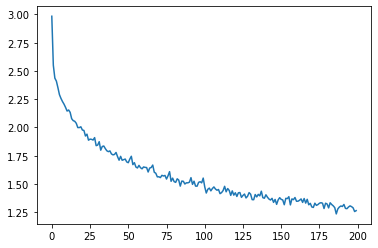

In [10]:
plt.figure()
plt.plot(all_losses)

In [11]:
def beam_search(rnn, cat_tensor, k=1, max_length=25):
    completed = []
    frontier = [(0, ['<SOS>'], rnn.initHidden())]

    for _ in range(max_length):
        extended_frontier = []

        # compute next char for each item in frontier
        for score, seq, hidden in frontier:

            char_tensor = torch.LongTensor([charToIndex(seq[-1])])
            output, hidden = rnn(cat_tensor, char_tensor, hidden)
            
            scores, idxs = output.squeeze().topk(k)

            # compute new scores for top next char prospects
            for s, i in zip(scores, idxs):
                unnormalized_score = score * len(seq)
                new_score = (unnormalized_score + s) / (len(seq) + 1)

                new_seq = seq + [all_letters[i]]
                new_item = (new_score, new_seq, hidden)

                if all_letters[i] == '<EOS>':
                    completed.append(new_item)
                else:
                    extended_frontier.append(new_item)

        if len(completed) >= k:
            break
        
        frontier = sorted(extended_frontier, reverse=True)[:k - len(completed)]

    res = []
    for score, seq, _ in sorted(completed, reverse=True)[:k]:
        res.append((score.item(), ''.join(seq[1:-1])))
    return res

In [12]:
def sample(category):
    cat_tensor = Variable(categoryTensor(category))
    return beam_search(rnn, cat_tensor, k=3)

for category in all_categories:
    outputs = sample(category)
    print('\n====== {}'.format(category))
    for score, seq in outputs:
        print(f'{score:.3f} {seq}')


====== German
-0.871 Scherm
-1.189 Kaufma
-1.275 Kaufm

====== Greek
-0.787 Tsouma
-1.085 Kouropou
-1.356 Kouro

====== Italian
-0.648 Carbone
-0.745 Albani
-1.069 Baro

====== English
-0.883 Macley
-0.994 Maclear
-1.226 Turn

====== Portuguese
-0.409 Machado
-0.440 Franco
-0.700 Mata

====== Chinese
-0.807 She
-0.884 Chi
-0.976 Che

====== Vietnamese
-0.515 Thao
-0.929 La
-1.293 Die

====== Irish
-0.506 Mahoney
-0.876 Conn
-1.010 Mahone

====== Spanish
-0.628 Araulla
-0.722 Marti
-1.130 Barro

====== Arabic
-0.521 Bazzi
-0.574 Assaf
-1.079 Baz

====== Polish
-0.594 Sokolof
-1.048 Sokol
-1.572 Koz

====== Dutch
-0.476 Romeijn
-0.669 Sneider
-1.437 Sneid

====== Czech
-0.858 Borovsk
-0.963 Koma
-1.131 Strak

====== Russian
-0.895 Babanov
-0.938 Balakov
-0.954 Babalov

====== French
-0.539 Bonnay
-0.779 Bouchar
-0.933 Bonnair

====== Scottish
-0.491 Maclean
-0.916 Marshal
-0.924 Macdonal

====== Korean
-0.817 You
-0.822 Chi
-0.930 Cho

====== Japanese
-0.594 Takemura
-0.813 Takeda
-0.85